<a href="https://colab.research.google.com/github/86lekwenshiung/West-Nile-Virus-Prediction/blob/main/Project_4_West_Nile_Virus_Terence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Libraries Import
___

In [1]:
# General Utilities
import datetime
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import geodesic
import shapely
from shapely.geometry import Point , MultiPoint
from shapely.ops import nearest_points

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Machine Learning Libraries

# 1.0 Data Import
___

In [2]:
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/test.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/spray.csv

--2021-11-02 14:08:21--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797335 (1.7M) [text/plain]
Saving to: ‘train.csv.9’

train.csv.9         100%[===================>]   1.71M  --.-KB/s    in 0.04s   

2021-11-02 14:08:21 (42.3 MB/s) - ‘train.csv.9’ saved [1797335/1797335]

--2021-11-02 14:08:22--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response.

### 1.1 Data Exploration on Train Dataset
___

In [3]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_spray = pd.read_csv('/content/spray.csv')
df_weather = pd.read_csv('/content/weather.csv')

#3.0 Feature Creation & Data Preprocessing
___

### 3.1 Date Features
___

In [4]:
def preprocess_date(df):
  df['Year'] = pd.to_datetime(df['Date']).dt.year
  df['Month'] = pd.to_datetime(df['Date']).dt.month
  df['WeekofYear'] = pd.to_datetime(df['Date']).dt.isocalendar().week

  return df

In [5]:
df_train = preprocess_date(df_train)
df_spray = preprocess_date(df_spray)
df_weather = preprocess_date(df_weather)

In [6]:
df_spray[df_spray.duplicated()].head()

,Date,Time,Latitude,Longitude,Year,Month,WeekofYear
485,2011-09-07,7:43:40 PM,41.983917,-87.793088,2011,9,36
490,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36
491,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36
492,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36
493,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36


In [7]:
# Drop off Time from df_spray
# Drop off duplicate from df_spray

df_spray.drop('Time' , axis  = 1 , inplace = True)
df_spray.drop_duplicates(keep = 'first' , inplace = True)

In [8]:
print(df_spray.shape)
df_spray.head()

(14294, 6)


,Date,Latitude,Longitude,Year,Month,WeekofYear
0,2011-08-29,42.391623,-88.089163,2011,8,35
1,2011-08-29,42.391348,-88.089163,2011,8,35
2,2011-08-29,42.391022,-88.089157,2011,8,35
3,2011-08-29,42.390637,-88.089158,2011,8,35
4,2011-08-29,42.390410,-88.088858,2011,8,35


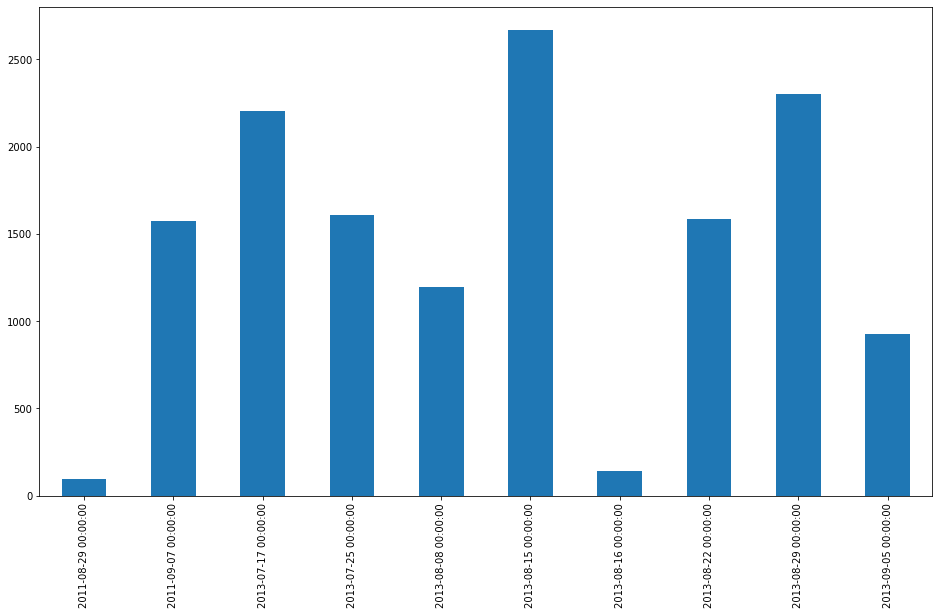

In [9]:
df_spray['Date'].astype('datetime64').value_counts().sort_index().plot(kind = 'bar' , figsize = (16,9));

### 3.2 Spray Cluster
___

In [10]:
df_spray['spray coordinate'] = [Point(x,y) for x,y in zip(df_spray['Latitude'] , df_spray['Longitude'])]

In [11]:
# Create trap coordinate 
df_train['trap coordinate'] = [Point(x,y) for x,y in zip(df_train['Latitude'] , df_train['Longitude'])]

# Create Spray coordinate
df_spray['spray coordinate'] = [Point(x,y) for x,y in zip(df_spray['Latitude'] , df_spray['Longitude'])]

# Convert spray coodinate to multipoint
spray_coord = MultiPoint(df_spray['spray coordinate'].to_list())

In [12]:
df_train['WnvPresent']

0        0
1        0
2        0
3        0
4        0
        ..
10501    1
10502    0
10503    0
10504    0
10505    0
Name: WnvPresent, Length: 10506, dtype: int64

In [13]:
# df_spray.shape , df_train.shape , len(dist)

In [14]:
# df_spray.merge(df_train , on  = [''])

In [15]:
dist = []

for trap_coord in df_train['trap coordinate']:

  nearest = nearest_points(trap_coord , spray_coord)

  a , b = (trap_coord.x , trap_coord.y) , (nearest[1].x , nearest[1].y)

  dist.append(geodesic(a,b).m)

# add distance to trap locations
df_train['dist_spray'] = dist
df_train['sprayed'] = df_train['dist_spray'].apply(lambda x: 0 if x > 1000 else 1)

In [16]:
df_train['sprayed'].value_counts()

0    7089
1    3417
Name: sprayed, dtype: int64

In [17]:
df_spray

,Date,Latitude,Longitude,Year,Month,WeekofYear,spray coordinate
0,2011-08-29,42.391623,-88.089163,2011,8,35,POINT (42.3916233333333 -88.0891633333333)
1,2011-08-29,42.391348,-88.089163,2011,8,35,POINT (42.3913483333333 -88.0891633333333)
2,2011-08-29,42.391022,-88.089157,2011,8,35,POINT (42.3910216666667 -88.0891566666667)
3,2011-08-29,42.390637,-88.089158,2011,8,35,POINT (42.3906366666667 -88.0891583333333)
4,2011-08-29,42.390410,-88.088858,2011,8,35,POINT (42.39041 -88.08885833333331)
...,...,...,...,...,...,...,...
14830,2013-09-05,42.006587,-87.812355,2013,9,36,POINT (42.00658666666671 -87.81235500000001)
14831,2013-09-05,42.006192,-87.816015,2013,9,36,POINT (42.0061916666667 -87.81601500000001)
14832,2013-09-05,42.006022,-87.817392,2013,9,36,POINT (42.0060216666667 -87.81739166666669)
14833,2013-09-05,42.005453,-87.817423,2013,9,36,POINT (42.0054533333333 -87.81742333333329)


### 3.3 Weather DF
___

In [18]:
df_weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WeekofYear
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,5,18
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,2007,5,18
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,5,18
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,2007,5,18
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0,2014,10,44
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,0622,1649,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5,2014,10,44
2941,2,2014-10-30,53,37,45,M,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.9,23,6.5,2014,10,44
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,0623,1647,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9,2014,10,44


In [19]:
# replace trace and missing precip with 0s
df_weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
df_weather.PrecipTotal = df_weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(df_weather.Tavg.value_counts()['M'])

# imputing Tavg manually (increases accuracy)
df_weather.Tavg = (df_weather.Tmax + df_weather.Tmin)/2
df_weather.Tavg = df_weather.Tavg.astype(float)

11


In [20]:
df_weather[df_weather['Station'] == 2]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WeekofYear
1,2,2007-05-01,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,2007,5,18
3,2,2007-05-02,60,43,51.5,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,2007,5,18
5,2,2007-05-03,67,48,57.5,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2,2007,5,18
7,2,2007-05-04,78,51,64.5,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4,2007,5,18
9,2,2007-05-05,66,54,60.0,M,39,50,5,0,-,-,,M,M,M,0.00,29.46,30.09,11.2,7,11.5,2007,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79,54,66.5,M,52,59,0,2,-,-,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6,2014,10,44
2937,2,2014-10-28,66,48,57.0,M,40,48,8,0,-,-,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6,2014,10,44
2939,2,2014-10-29,49,40,44.5,M,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0,2014,10,44
2941,2,2014-10-30,53,37,45.0,M,35,42,20,0,-,-,RA,M,M,M,0.00,29.41,30.10,5.9,23,6.5,2014,10,44


In [21]:
df_weather = df_weather[df_weather['Station'] == 2]

In [22]:
df_train = pd.merge(df_train, df_weather , on=['Date', 'Year', 'WeekofYear', 'Month'] , how = 'left')

In [23]:
# Note that shape changes to double because there are 2 stations for a single coordinate.

print('DF weather shape :' ,  df_weather.shape)
print('DF train shape :' ,  df_train.shape)

DF weather shape : (1472, 25)
DF train shape : (10506, 39)


# 4.0 Preprocessing Dataframe
___

### 4.1 Dropping Redundant Col
___

In [24]:
df_train.drop(['AddressAccuracy','Address','Street','AddressNumberAndStreet'],axis=1,inplace=True)
df_train.drop(['Water1','Depart','Depth','SnowFall','AvgSpeed','ResultSpeed','ResultDir','SeaLevel','StnPressure','CodeSum','Heat','Cool'],axis=1,inplace=True)
df_train.drop(['trap coordinate'],axis=1,inplace=True)

In [25]:
df_train.columns

Index(['Date', 'Species', 'Block', 'Trap', 'Latitude', 'Longitude',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'WeekofYear',
       'dist_spray', 'sprayed', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint',
       'WetBulb', 'Sunrise', 'Sunset', 'PrecipTotal'],
      dtype='object')

### 4.2 Preprocessing Dataframe
___

In [26]:
def preprocess_df(df):
  # df['NumMosquitos'] = df['NumMosquitos'].fillna(0)
  # df['WnvPresent'] = df['WnvPresent'].fillna(0)
  df['Species'] = df['Species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1}) \
                                   .fillna(0)

  df['Trap'] = df['Trap'].astype('category').cat.codes
  df.isin(['-']).sum()[df.isin(['-']).sum() > 0].sort_values(ascending=False)
  df['Sunrise'] = np.where(df['Sunrise'].isin(['-']), 0 ,df['Sunrise'])
  df['Sunset'] = np.where(df['Sunset'].isin(['-']), 0 ,df['Sunset'])
  df['WetBulb'] = np.where(df['Sunset'].isin(['-']) , 0 , df['WetBulb'])
  df['WetBulb'] = np.where(df['WetBulb'].isin(['M']) , df['WetBulb'].mode() , df['WetBulb'])

  return df                                     

In [27]:
df_train_processed = preprocess_df(df_train)

In [28]:
X = df_train_processed.drop(['Date','WnvPresent' , 'NumMosquitos' , 'sprayed' , 'dist_spray'], axis=1)
y = df_train_processed['WnvPresent']

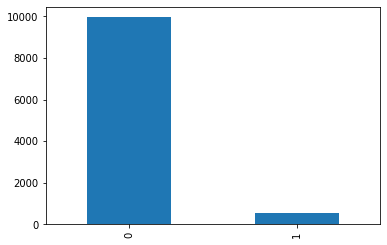

In [29]:
y.value_counts().plot(kind = 'bar');

### 4.3 Fitting into Model (Baseline No Smote)
___

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [31]:
X_train_smote, y_train_smote = X_train , y_train

In [32]:
df_train_processed

,Date,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,WeekofYear,dist_spray,sprayed,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal
0,2007-05-29,2.0,41,1,41.954690,-87.800991,1,0,2007,5,22,255.770357,1,2,88,65,76.5,59,66,0,0,0.0
1,2007-05-29,1.0,41,1,41.954690,-87.800991,1,0,2007,5,22,255.770357,1,2,88,65,76.5,59,66,0,0,0.0
2,2007-05-29,1.0,62,6,41.994991,-87.769279,1,0,2007,5,22,347.488585,1,2,88,65,76.5,59,66,0,0,0.0
3,2007-05-29,2.0,79,13,41.974089,-87.824812,1,0,2007,5,22,11.224465,1,2,88,65,76.5,59,66,0,0,0.0
4,2007-05-29,1.0,79,13,41.974089,-87.824812,4,0,2007,5,22,11.224465,1,2,88,65,76.5,59,66,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,2.0,51,25,41.763733,-87.742302,6,1,2013,9,39,860.271370,1,2,75,55,65.0,52,58,0,0,0.0
10502,2013-09-26,2.0,58,127,41.987280,-87.666066,5,0,2013,9,39,108.214816,1,2,75,55,65.0,52,58,0,0,0.0
10503,2013-09-26,2.0,17,128,41.912563,-87.668055,1,0,2013,9,39,1078.872587,0,2,75,55,65.0,52,58,0,0,0.0
10504,2013-09-26,2.0,71,129,42.009876,-87.807277,5,0,2013,9,39,44.600309,1,2,75,55,65.0,52,58,0,0,0.0


In [33]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'xgb': XGBClassifier(random_state=42),
        }

In [34]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_smote, y_train_smote)
        pipe = gs
        
    else:
        pipe.fit(X_train_smote, y_train_smote)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train_smote)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train_smote, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [35]:
def predictions(pipeline):
    pipeline.fit(X_train_smote.values,y_train_smote.values) #fit pipeline to training data
    a = [pipeline.predict(X_train_smote.values), 
 #      pipeline.predict(X_val.values),
       pipeline.predict(X_test.values)]
    b = [pipeline.predict_proba(X_train_smote.values),
 #      pipeline.predict_proba(X_val.values),
       pipeline.predict_proba(X_test.values)]
    return a,b

In [36]:
xgb = run_model('xgb')

### METRICS ###


{'f_score': 0.012048192771084336,
 'model': 'xgb',
 'precision': 1.0,
 'recall': 0.006060606060606061,
 'specificity': 1.0,
 'test_auc': 0.842756997494192,
 'train_auc': 0.8890317617770058}

True Negatives: 2987
False Positives: 0
False Negatives: 164
True Positives: 1


In [37]:
rfc = run_model('rf')

### METRICS ###


{'f_score': 0.24719101123595508,
 'model': 'rf',
 'precision': 0.3235294117647059,
 'recall': 0.2,
 'specificity': 0.9768998995647807,
 'test_auc': 0.7742723519087764,
 'train_auc': 0.9866101437808963}

True Negatives: 2918
False Positives: 69
False Negatives: 132
True Positives: 33


### 4.4 Fitting into Model (With Smote)
___

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [39]:
# borderline-SMOTE with SVM for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
smote = SMOTEENN()
#X, y = smote.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9955, 1: 551})
Counter({0: 9955, 1: 551})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [40]:
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [41]:
print('Before SMNOTE :', np.bincount(y_train))
print('After SMNOTE :', np.bincount(y_train_smote))

Before SMNOTE : [6968  386]
After SMNOTE : [5587 5641]


In [42]:
xgb_s = run_model('xgb')

### METRICS ###


{'f_score': 0.2664796633941094,
 'model': 'xgb',
 'precision': 0.17335766423357665,
 'recall': 0.5757575757575758,
 'specificity': 0.8483428188818212,
 'test_auc': 0.8251047468322327,
 'train_auc': 0.989920014956086}

True Negatives: 2534
False Positives: 453
False Negatives: 70
True Positives: 95


In [43]:
rfc_s = run_model('rf')

### METRICS ###


{'f_score': 0.24766355140186916,
 'model': 'rf',
 'precision': 0.20152091254752852,
 'recall': 0.3212121212121212,
 'specificity': 0.9296953465015065,
 'test_auc': 0.7627233161883313,
 'train_auc': 1.0}

True Negatives: 2777
False Positives: 210
False Negatives: 112
True Positives: 53


In [44]:
gb_s = run_model('gb')

### METRICS ###


{'f_score': 0.2563380281690141,
 'model': 'gb',
 'precision': 0.1669724770642202,
 'recall': 0.5515151515151515,
 'specificity': 0.8480080348175427,
 'test_auc': 0.816553550232827,
 'train_auc': 0.9911467306708629}

True Negatives: 2533
False Positives: 454
False Negatives: 74
True Positives: 91


In [45]:
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,xgb,0.889032,0.842757,1.000000,1.000000,0.006061,0.012048
1,xgb,0.989920,0.825105,0.173358,0.848343,0.575758,0.266480
2,gb,0.991147,0.816554,0.166972,0.848008,0.551515,0.256338
3,rf,0.986610,0.774272,0.323529,0.976900,0.200000,0.247191
4,rf,1.000000,0.762723,0.201521,0.929695,0.321212,0.247664


In [46]:
model = RandomForestClassifier(random_state = 42 , n_estimators = 1000)
model.fit(X_train_smote , y_train_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# 5.0 Preprocess test Data
___

In [47]:
df_test = pd.read_csv('/content/test.csv')
df_test = preprocess_date(df_test)

df_test = pd.merge(df_test, df_weather , on=['Date', 'Year', 'WeekofYear', 'Month'] , how = 'left')
df_test.drop(['AddressAccuracy','Address','Street','AddressNumberAndStreet'],axis=1,inplace=True)
df_test.drop(['Water1','Depart','Depth','SnowFall','AvgSpeed','ResultSpeed','ResultDir','SeaLevel','StnPressure','CodeSum','Heat','Cool'],axis=1,inplace=True)

In [48]:
df_test_processed = preprocess_df(df_test)

In [49]:
df_test_processed_id = df_test_processed['Id']
X_test = df_test_processed.drop(['Id' , 'Date'] , axis = 1)
X_test.shape , X_train.shape

((116293, 17), (7354, 17))

In [52]:
y_pred = model.predict_proba(X_test)

In [54]:
y_pred[: , 0]

array([0.941, 0.964, 0.941, ..., 0.727, 0.727, 0.727])

In [55]:
df_submission = pd.DataFrame({'Id' : df_test_processed_id,
                              'WnvPresent' : y_pred[: , 0]})

df_submission.to_csv(path_or_buf = 'df_submission.csv' , index = False)

In [56]:
df_submission

,Id,WnvPresent
0,1,0.941
1,2,0.964
2,3,0.941
3,4,0.964
4,5,0.964
...,...,...
116288,116289,0.727
116289,116290,0.727
116290,116291,0.727
116291,116292,0.727


In [57]:
y_pred

array([[0.941, 0.059],
       [0.964, 0.036],
       [0.941, 0.059],
       ...,
       [0.727, 0.273],
       [0.727, 0.273],
       [0.727, 0.273]])